First of all some imports

In [1]:
import numpy as np 
import pandas as pd 

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Activation, Dropout, DepthwiseConv2D
from keras.layers.pooling import GlobalAveragePooling2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

import os
print(os.listdir("../input"))

Using TensorFlow backend.


['train.csv', 'sample_submission.csv', 'test.csv']


Loading the data

In [2]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')

Split the data into images and labels

In [3]:
x_train = train_data.drop(labels = ['label'], axis = 1)
y_train = train_data['label']

Free some space

In [4]:
del train_data

Some visualization

In [5]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

Now we normalize the training and test data

In [6]:
x_train = x_train / 255.0
test_data = test_data / 255.0

Now we need to reshape the data (28,28,1)

In [7]:
x_train = x_train.values.reshape(-1, 28, 28, 1)
test_data = test_data.values.reshape(-1, 28, 28, 1)

Now we encode the labels to one hot encoded vectors

In [8]:
y_train = to_categorical(y_train, num_classes = 10)

set the random seed

In [9]:
random_seed = 2

Split training and validation data 

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.15, random_state = random_seed)

Now we create the model

In [11]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())

    model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())

    model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())

    model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    model.add(Dense(512, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation = "softmax"))
    
    model.compile(Adam(lr = 0.003), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [12]:
model = create_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

Now we do some data augmentation

In [13]:
data_generator = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        zca_whitening = False,
        rotation_range = 15,
        zoom_range = 0.15,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = False,
        vertical_flip = False)

In [14]:
data_generator.fit(x_train)

Now some important variables

In [15]:
epochs = 50
batch_size = 32
train_step_size = x_train.shape[0] // batch_size
weights_file_path = 'mnist_weights.h5'

Now we define the callbacks we'll use while training

In [16]:
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.75, min_lr = 0.00001)
checkpoint = ModelCheckpoint(weights_file_path, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 1e-10, patience = 10, verbose = 1, restore_best_weights = True)

callbacks = [reduce_learning_rate, checkpoint, early_stopping]

Finally we train the model

In [17]:
history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs,
                              validation_data = (x_val, y_val),
                              verbose = 1,
                              steps_per_epoch = train_step_size,
                              callbacks = callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1115/1115 [==============================] - 22s 20ms/step - loss: 0.4925 - acc: 0.8497 - val_loss: 0.2403 - val_acc: 0.9210

Epoch 00001: val_acc improved from -inf to 0.92095, saving model to mnist_weights.h5
Epoch 2/50
1115/1115 [==============================] - 18s 16ms/step - loss: 0.1763 - acc: 0.9475 - val_loss: 0.0471 - val_acc: 0.9857

Epoch 00002: val_acc improved from 0.92095 to 0.98571, saving model to mnist_weights.h5
Epoch 3/50
1115/1115 [==============================] - 18s 16ms/step - loss: 0.1330 - acc: 0.9611 - val_loss: 0.0473 - val_acc: 0.9848

Epoch 00003: val_acc did not improve from 0.98571
Epoch 4/50
1115/1115 [==============================] - 18s 16ms/step - loss: 0.1161 - acc: 0.9667 - val_loss: 0.0641 - val_acc: 0.9811

Epoch 00004: val_acc did not improve from 0.98571
Epoch 5/50
1115/1115 [==============================] - 18s 16ms/step - loss: 0.1004 - acc: 0.9717 - val_loss: 0.0519 - val_acc: 0.

Now we predict the results 

In [18]:
predict_model = create_model()
predict_model.load_weights(weights_file_path)

predictions = predict_model.predict(test_data)

A helper functions to plot training curves and confusion matrix

In [19]:
def plot_training_curves(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.figure()
    
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.figure()
    
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

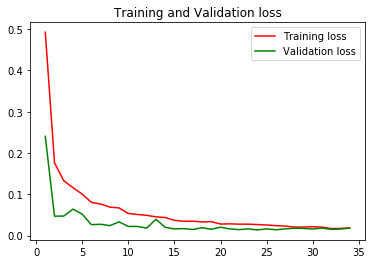

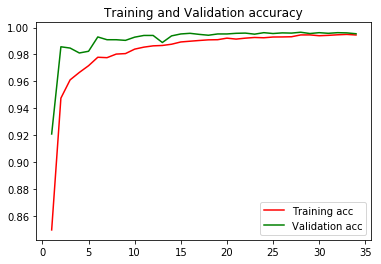

<Figure size 432x288 with 0 Axes>

In [20]:
plot_training_curves(history)

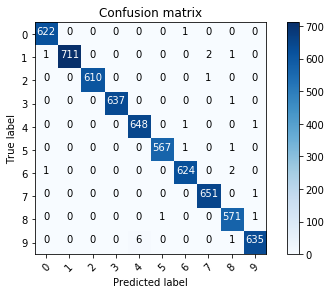

In [21]:
y_pred = model.predict(x_val)

y_pred_classes = np.argmax(y_pred,axis = 1) 

y_true = np.argmax(y_val,axis = 1) 

confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [22]:
predictions = np.argmax(predictions,axis = 1)

predictions = pd.Series(predictions,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"), predictions],axis = 1)

submission.to_csv("mnist_submission.csv",index=False)